<a href="https://colab.research.google.com/github/cedamusk/final-year/blob/main/finalyearproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enhancing Seismic Event Detection Using Recurrent Neural Networks on STA/LTA Detection Algorithm

## Introduction
The Short-Term Average/ Long-Term Average (STA/LTA) detection algoritm is a widely used method in seismic event detection commonly employed in real-time seismic monitoring systems to automatically identify earthquakes.

Recurrent Neural Networks are a type of Artificial Neural Network that are specifically designed to handle sequential data by incorporating feedback loops that allow information to persist across time steps.

The purpose of this script is to enhance the detection of seismic events by using an RNN model on the STA/LTA detection algorithm.



## Install dependencies
This command installs Python librabries that are going to be used in this script.



1.   **ObsPy**: A powerful library for processing seismic data. Provides tools for acccessing data from seismic data from seismic networks, filtering and visualizing seismic waveforms.
2.   **Tensorflow**: A machine learning framework developed by Google. Used for building, training and deploying machine learning models, icluding neural networks like RNNs, CNNs and more.
3. **Matplotlib**: Used for plotting in Python. Enables data visualization, including line plots, scatter plots, and more. Useful for displaying seismic waveforms or model performance mettrics.





In [ ]:
!pip install obspy tensorflow matplotlib

## Import Libraries and modules
This code imports various libraries and modules for handling seismic data and building mchine learning models.

### Numerical and Visualization libraries
`numpy`: Provides support for numerical operations and handling arrays

`matplotlib.pyplot`: Used for plotting graphs, such as visualizing waveforms or performance metrics.

`seaborn`: A statistical data visualiation library built on top of Matplotlib for more advanced and aesthetically pleasing plots.

### Seismic Data Handling(ObsPy)
`UTCDateTime`: Handles timestamps for seismic events in a format suitable for geophysical data.

`Stream` and `Trace`: Core data structures in ObsPy for handling seismic waveform data.

`Client`: Used to fetch seismic data from remote data centers like IRIS.

`classic_sta_lta`: A method for detecting seismic events using the Short-Term Average/Long-Term Average (STA/LTA) algorithm.

`bandpass`: Filters seismic data within a specific frequency range, which is crucial for noise reduction and signal enhancement.

### Machine Learning (Tensorflow/Keras)
`Sequential`: A keras model for stacking layers sequentially.

`LSTM`: A long Sort-Term Memory layer for capturing temporal dependencies in sequential data.

`Dense`: A fully connected neural network layer.

`Dropout`: Prevents overfitting by randomly setting a fraction of input units to 0 during training.

`BatchNormalization`: Normalizes inputs across a mini-batch, improving training speed and stability.

`Bidirectional`: Wraps and LSTM layer to process sequences in both forward and backward directions.

`EarlyStopping`: Stops training when performance on the validation set stops improving.

`ReduceLROnPlateau`: Reduces the learning rate when a metric has stopped improving.

`Adam`: An optimizer for adjusting weights during model training.

### Performance Evaluation (sckit-learn)
`precision_score`, `recall_score`, `f1_score`: Metrics for evaluating classification model performance.

`classification_report`: Provides a summary of precision, recall, F1-score and support for each class.

`confusion_matrix`: Displays a matrix comparing predicted and actual classifications.

`accuracy_score`: Calculates the overall accuracy of the model.





In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from obspy import UTCDateTime, Stream, Trace
from obspy.clients.fdsn import Client
from obspy.signal.trigger import classic_sta_lta
from obspy.signal.filter import bandpass
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

In [ ]:
def fetch_iris_data(network, station, location, channel, start_time, end_time):
  """
  Fetch seismic data from IRIS database
  """
  try:
    client=Client("IRIS")
    stream=client.get_s(network, station, location, channel, start_time, end_time)
    return stream
  except Exception as e:
    print(f"Error fetching data from IRIS: {str(e)}")
    return None

## Generate synthetic data
The function `generate_synthetic_data` generates synthetic data for testing and validation purposes. The generated data simulates background noises along with one or more seismic events, making it suitable for training and evaluating algorithms designed to detect seismic activity.

`num_samples` (int): This is the total number of smaples in the synthetic signal.

`sample_rate`(int): Is the number of samples per second, used to define the time axis of the signal.

`event_duration`(float): Duration of each syntetic evet in seconds.

`noise_level` (float): Standard deviationof the Gaussian noise added to simulate background seismic noise.

`data`(ndarray): A 1D array representing the synthetic signal, which includes both noise and seismic events.

`events`(ndarray): A 1D array containing only the synthetic seismic events witout noise, useful for comparison and validation.

`event_locations`(tuples): A list of tuples where each tuple contains the start and end indices of a seismic event in the `data` array.

### How the function works
**Time axis creation**: The function creates a time array using `num_samples` and `sample_rate`.

**Background Noise Generation**: Gaussian noise is generated using `np.random.normal` to simulate continuous background seismic noise.

**Seismic Event Creation**: A random number of events (between 1 and 3) is generated. For each event; a random starting point is selected witin the midlle 3/4 of the signal, event characteristics (frequency, amplitude, and exponential decay) are randomly assigned, and a sinusoidal waveform is generated, simulating a seismic event with an exponential decaying amplitude.

**Event addition**: The generated events are added to the noise to form the final synthetic signal.

**Return Values**: The function returns the complete synthetic signal, the isolated events and their corresponding locations in the signal.

In [ ]:
def generate_synthetic_data(num_samples, sample_rate, event_duration, noise_level):
  """
  Generate synthetic seismic data for testing and validation
  """
  time=np.arange(num_samples)/sample_rate
  background=np.random.normal(0, noise_level, num_samples)

  #Create multiple events for more complex training
  num_events=np.random.randint(1,4)
  events=np.zeros(num_samples)
  event_locations=[]

  for _ in range(num_events):
    event_start=np.random.randint(num_samples // 8, num_samples * 7//8)
    event_end=event_start + int(event_duration *sample_rate)
    event_locations.append((event_start, event_end))

    #Create event with varying frequency and amplitude
    freq=np.random.uniform(3, 8)
    amp=np.random.uniform(0.8, 1.2)
    decay=np.random.uniform(0.1, 0.3)

    event=np.sin(2*np.pi*freq*(time[event_start:event_end]-time[event_start]))*\
          amp*np.exp(-(time[event_start:event_end]-time[event_start])/ decay)
    events[event_start:event_end]=event

  data =background +events
  return data, events, event_locations



## Feature Engineering
The function `create_windows` generates sliding windows from a time series dataset. Each window includes engineered features to prepare the data for training recurrent neural networks (RNNs) or other machine learning models.

`data`(ndarray): A 1D array representing the time-series data.

`window_size`(int): The number of data points in each sliding window.

`step`(int): The step size between consecutive windows. Smaller step sizes result in overlapping windows.

`windows`(ndarray): A 3D array where each entry is a sliding window with engineered features:
  1. Column 1: Raw signal values
  2. Column 2: Absolute amplitude of the signal.
  3. Column 3: First derivative (rate of change) of the signal.
  4. Column 4: Second derivative (acceleration) of the signal.

`labels`(ndarray): A 1D array where each label corresponds to the mean value of the raw signal in its respective window.

### How it works

**Sliding Window Creation**: The function iterates over the `data` array using a sliding window approach. For each window, it extracts `window_size` points from index `i` moving by `step`.

**Feature engineering**: For each window, four features are computed and stacked; The raw signal, absolute value of the signal, First derivtive (using `np.gradient`) and the second derivative (also using `np.gradient`).

**Label assignment**: Each window is assigned a label, which is the mean of the raw signal values within the window.

**Output**: Returns arrays of feature-engineered windows and their corresponding labels.


In [ ]:
def create_windows(data, window_size, step):
  """
  Create sliding windows for RNN input with overlap
  """
  windows=[]
  labels=[]

  for i in range(0, len(data)- window_size +1, step):
    window=data[i:i+window_size]

    #Add Feature engineering
    window_features=np.column_stack((
        window, #raw signal
        np.abs(window), #absolute amplitude
        np.gradient(window), #First deravitive
        np.gradient(np.gradient(window)) #Second derivative
    ))
    windows.append(window_features)

    if len(window)==window_size:
      labels.append(window.mean())
  return np.array(windows), np.array(labels)

## Model Building
This function builds a sophisticated recurrent neural network (RNN) model using multiple Long Short-Term Memory (LSTM) layers. The model is designed for binary classification tasks, enhanced with bidirectional LSTMs dropout layers, and Batch normalization for improved performance and generalization.

###Key components
**Bidirectional LSTMs**: Captures both past and future dependencies in the sequence data. Enhances the model's ability to learn complex temporal patterns.

**Batch Normalization**: Normalizes activations of each layer to improve training stability and convergence.

**Dropout**: Reduces overfitting by randomly deactivating a fraction of neurons during training.

**Dense layers**: Fully connected layers of classification, transforming LSTM outputs into the final prediction.

**Output layer**: A single neuron with a sigmoid activation function for binary classification (outputs probabilities between 0 and 1).

### Parameters
`input_shape` (tuple): Shape of the input data excluding the batch size, typically (`time_steps`, `features`)

### Model Architecture
1. **Layer 1**: Bidirectional LSTM with 128 units (returns sequences). Batch Normaliation and 30% dropout.
2. **Layer 2**: Bidirectional LSTm with 96 units (returns sequences). Batch Normaliation and 30% dropout.
3. **Layer 3**: LSTM with 64 units (no sequences returned). Batch Normalization and 20% dropout.
4. **Dense layers**: 32 and 16 neurons with ReLU activation. Batch normaliation and 20% dropout applied to the first dense layer.
5. **Output layer**: Single neuron with sigmoid activation for binary classification.

### Compilation
**Optimizer**: Adam optimizer with a custome learning rate of 0.001.

**Loss function**: Binary cross-entropy, appropriate for binary classification tasks.

**Metrics**: The model evaluates performance using `accuracy`, `precision`, `recall`.

 `model` returns a compiled TensorFlow Keras model ready for training.


In [ ]:
def build_enhanced_rnn_model(input_shape):
  """
  Build an enhanced RNN model with multiple LSTM layers and additional features
  """
  model=Sequential([
      # First Bidirectional LSTM Layer
      Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape),
      BatchNormalization(),
      Dropout(0.3),

      #Second Bidirectional LSTM layer
      Bidirectional(LSTM(96, return_sequences=True)),
      BatchNormalization(),
      Dropout(0.3),

      #Third LSTM Layer
      LSTM(64),
      BatchNormalization(),
      Dropout(0.2),

      #Dense layer for classification
      Dense(32, activation='relu'),
      BatchNormalization(),
      Dropout(0.2),
      Dense(16, activation='relu'),
      Dense(1, activation='sigmoid')

  ])

  # Use Adam optimizer with custom learning rate
  optimizer=Adam(learning_rate=0.001)

  model.compile(
      optimizer=optimizer,
      loss='binary_crossentropy',
      metrics=['accuracy', 'Precision', 'Recall']
  )

  return model

## Seismic data preprocessing
This function preprocesses seismic data by applying a series of standard signal processing steps, including detrending, tapering and bandpass filtering. The goal is to enhance the signal quality and remove unwanted noise for further analysis and modelling.

### Parameters
1. `stream` (`obspy.Stream`): The input seismic data stream to be processed. It may contain one or more traces of raw seismic data.

2. `freqmin` (float, default=0.5): The minimum frequency for the bandpass filter, used to remove low-frequency noise.

3. `freqmax` (float, default=20): The maximum frequency for the bandpass filter, used to remove high-frequency noise.

### Returns
`processed_stream (`obspy.Stream`): A copy of input stream with the followimg preprocessing steps applied.

### Processing steps
**Detrending**: Removes any linear trend from the data to correct for baseline drift. Uses the `linear` detrending method to ensure that the mean of the signal is zero.

**Tapering**: Applies a tapering function to the edges of the signal to reduce spectral leakage during filtering. The taper affects up to 5% of the signal at both ends (`max_percentage=0.05`).

**Bandpass Filtering**: Filters the signal to retain only frequencies within the range [`freqmin`, `freqmax`]. Uses a 4th order Butterworth filter (`corners=4`) with zero-phase filtering (`zerophase=True`) to avoid phase distortion.

In [ ]:
def process_stream(stream, freqmin=0.5, freqmax=20):
  """
  Process a seismic stream with enhanced filtering
  """
  processed_stream=stream.copy()
  processed_stream.detrend('linear')
  processed_stream.taper(max_percentage=0.05)
  processed_stream.filter('bandpass', freqmin=freqmin, freqmax=freqmax,
                          corners=4, zerophase=True)
  return processed_stream

## Model Evaluation
This function evaluates the performance of a trained binary classification model on a dataset. It calculates the various performance metrics, generates a classification report, and visualizaes the confusion matrix to provide a comprehensive analysis of the model's predictive capabilities.

### Parameters
1. `model` (`keras.Model`): The trained Keras model to be evaluated.
2. `X_test`(ndarray): Test features used for evaluation.
3. `y_test`(ndarray): True labels for the dataset.
4. `predictions`(ndarray): The predicted probabilities output by the model for `X_test`.

### Returns
`accuracy` (float): The accuracy of the model on the test set.
`precision`(float): The precision score indicating the proportion of positive identifications that were correct.
`recall` (float): The recall score, showing the proportion of actual positives identified correctly.
`f1` (float): the F1 Score, the harmonic mean of precision and recall.

### Steps and Outputs
1. **Binary predictions**: Converts predicted probabilities into binary class predictions using a threshold of `0.5`.
2. **Performance metrics**: **Accuracy**: the proportion of correct predictions. **Precision**: The ratio of true positives of all predicted positives. **Recall**: the raitio of true positives to all actual positives. **F1 Score**: A balanced measure of precision and recall

3. **Classificatio report**: Provides a detailed report showing precision, recall, F1-score and support for each class.

4.**Confusion matrix**: Visualizes te confusion matrix as a heatmap, showing the distriution of true vs predicted labels.

In [ ]:
def evaluate_model(model, X_test, y_test, predictions):
  binary_predictions=(predictions>0.5).astype(int)

  accuracy=accuracy_score(y_test, binary_predictions)
  precision=precision_score(y_test, binary_predictions)
  recall=recall_score(y_test, binary_predictions)
  f1=f1_score(y_test, binary_predictions)

  report=classification_report(y_test, binary_predictions)

  cm=confusion_matrix(y_test, binary_predictions)

  print("\n===Model Performance Metrics===")
  print(f"Accuracy:{accuracy:.4f}")
  print(f"Precision:{precision:.4f}")
  print(f"Recall:{recall:.4f}")
  print(f"F1 Score:{f1:.4f}")

  print("\n=== Classification report===")
  print(report)

  plt.figure(figsize=(8,6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.title('Confusion Matrix')
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.show()

  return accuracy, precision, recall, f1

## Main
Tis function serves as the entry oint for a seismic event detection pipeline. It orchestrates the workflow, from data acquisition to model training and evaluation, providing flexibility to use either real seismic data or synthetic data.

### Key components
1. **Configuration Parameters** (`config`):
Defines various parameters for data processing and model training:
`window_size`: Sie for sliding windows for input features
`step`: Step size for sliding windows.
`sample_rate`: Smapling rate of seismic data.
`sta_length` and `lta_length`: Parameters for STA/LTA detection.
`threshold`: Detection threshold for triggers.
`num_samples`: Number of samples for synthetic data generation.

###Data Acquisition
**Real Data**: Fetches seismic data from the IRIS database for the lat hour using the `fetch_iris_data` funstion.
**Synthetic data**: Generates synthetic seismic data with multiple events using the `generate_synthetic_data` function if real data is unavailable.

### Data Preprocessing
Applies filtering to the seismic stream using the `process_stream` function.
Creates input features and labels using `create_windows`.

###Labelling
For real data, labels are generated using STA/LTA triggers.
For synthetic data, labels are generated based on the presence of events.

###Data normalization and Splitting
Splits the data into training and testing using `train_test_split`.
Normalizaes data using the mean and standard deviation and learning rate reduction callbacks.

###Model evaluation
Makes predictions on the test set.
Evaluates the model using `evaluate_model`, calculating accuracy, precision, recall and F1 Score.

###Visualization
Visualizaes the results using `plot_results` and plots the training history with `plot_training_history`.

In [ ]:
def main(use_real_data=True):
  #Configuration parameters
  config={
      'window_size':200,
      'step':20,
      'sample_rate':100,
      'sta_length':50, #0.5 seconds
      'lta_length':500, #5 Seconds
      'threshold':1.5,
      'num_samples':20000
  }

  if use_real_data:
    #Fetch real data from IRIS
    end_time=UTCDateTime.now()
    start_time=end_time-3600

    stream=fetch_iris_data('YS', "BAOP", "", "BHZ", start_time, end_time)
    if stream is None:
      print("Falling back to synthetic data...")
      use_real_data=False
    else:
      filtered_stream=process_stream(stream)

  if not use_real_data:
    # Genearate synthetic data with multiple events
    synthetic_data, true_events, event_locations=generate_synthetic_data(
        config['num_samples'],
        config['sample_rate'],
        event_duration=2,
        noise_level=0.1
    )
    trace= Trace(data=synthetic_data)
    trace.stats.starttime=UTCDateTime("2021-01-01T00:00:00")
    trace.stats.delta=1.0/config['sample_rate']
    trace.stats.channel='SHZ'
    filtered_stream=Stream([trace])
    filtered_stream=process_stream(filtered_stream)

  #Create training data
  X, y=create_windows(
      filtered_stream[0].data,
      config['window_size'],
      config['step']
  )
  if use_real_data:
    #For real data, use STA/LTA triggers as initial labels
    triggers, sta_lta=sta_lta_detection(
        filtered_stream,
        config['sta_length'],
        config['lta_length'],
        config['threshold']
    )
    y=(y>config['threshold']).astype(int)
  else:
    y=(y>0).astype(int)

  print(f"X shape: {X.shape}")
  print(f"y shape: {y.shape}")

  #Prepare data for training
  X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)

  #Normalize data
  mean=X_train.mean(axis=(0,1), keepdims=True)
  std=X_train.std(axis=(0,1), keepdims=True)
  X_train=(X_train -mean)/std
  X_test=(X_test-mean) /std

  #Build and train model
  input_shape=(config['window_size'], X.shape[2])
  model=build_enhanced_rnn_model(input_shape)

  #Add callbacks
  callbacks=[
      EarlyStopping(
          monitor='val_loss',
          patience=10,
          restore_best_weights=True
      ),
      ReduceLROnPlateau(
          monitor='val_loss',
          factor=0.5,
          patience=5,
          min_lr=1e-6
      )
  ]
  #Train Model
  history=model.fit(
      X_train, y_train,
      epochs=100,
      batch_size=32,
      validation_split=0.2,
      callbacks=callbacks,
      verbose=1
  )

  # Make Predictions
  predictions=model.predict(X_test)
  accuracy, precision, recall, f1=evaluate_model(model, X_test, y_test, predictions)

  #plot results
  plot_results(filtered_stream, predictions, config, use_real_data, metrics={'accuracy':accuracy, 'precision': precision, 'recall':recall, 'f1':f1})
  plot_training_history(history)

## Plot Results
The purpose of this function is to visualize the outcomes of the seismic event detection process. It lots the original seismic data, model predictions and binary classification results to offer insights into the model's performance.

### Key Features
**Original Seismic Data**: Displays the raw seismic signal. Helps assess the data quality and structure.

**Prediction probabilities**: Plots the model's predicted probabilities for seismic event detection. Indicates how confident the model is about each window containing an event.

**Binary Predictions**: Converts predicted probabilities into binary classifications using a threshold of 0.5. Shows detected events as binary indicators (1 for detected, 0 for not detected).

**Performance Metrics overlay**: Displays evaluation metrics (accuracy, precision, recal F1 score) on the plot for quick reference.

### Parameters
`stream`(`Stream`): The processed seismic data containing raw or synthetic data.

`predictions`(`ndarray`): Predicted probabilities for each window, generated by the model.

`config`(`dict`): configuration used in the detection pipeline.

`use_real_data`(`bool`): Specifies whether the data is real or synthetic.

`metrics`(`dict`): Contains evaluation metrics. If provided, these metrics are displayed on the plot.

In [ ]:
def plot_results(stream, predictions, config, use_real_data, metrics=None):
  plt.figure(figsize=(15, 12))

  #Plot original data
  plt.subplot(3,1,1)
  plt.plot(stream[0].data, color='navy', linewidth=1.5)
  plt.title("Original Seismic Data", fontsize=12, fontweight='bold')
  plt.xlabel("Samples", fontsize=10)
  plt.ylabel("Amplitude", fontsize=10)

  if metrics:
    plt.text(0.02, 0.988,
             f"Accuracy: {metrics['accuracy']:.4f}\n"
             f"Precision: {metrics['precision']:.4f}\n"
             f"Recall: {metrics['recall']:.4f}\n"
             f"F1 Score:{metrics['f1']:.4f}",
             transform=plt.gca().transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    plt.subplot(3,1,2)
    plt.plot(predictions, color='green', linewidth=1.5, alpha=0.7)
    plt.title("Detection Prediction Probabilities", fontsize=12, fontweight='bold')
    plt.xlabel("Windows", fontsize=10)
    plt.ylabel("Probability", fontsize=10)
    plt.ylim(0,1)
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.subplot(3,1,3)
    binary_preds=(predictions>0.5).astype(int)
    plt.plot(binary_preds, color='red', linewidth=1.5)
    plt.title("Binary Predictions(Threshold=0.5)", fontsize=12, fontweight='bold')
    plt.xlabel("Windows", fontsize=10)
    plt.ylabel("Detection", fontsize=10)
    plt.ylim(-0.1, 1.1)
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()



In [ ]:
def plot_training_history(history):
  plt.figure(figsize=(15,5))

  plt.subplot(1,3,1)
  plt.plot(history.history['loss'], label="Training Loss", color='blue')
  plt.plot(history.history['val_loss'], label='Validatio loss', color='red')
  plt.title('Model Loss', fontsize=12, fontweight='bold')
  plt.xlabel('Epoch', fontsize=10)
  plt.ylabel('loss', fontsize=10)
  plt.legend()
  plt.grid(True, linestyle='--', alpha=0.7)

  plt.subplot(1,3,2)
  plt.plot(history.history['accuracy'], label='Training accuracy', color='green')
  plt.plot(history.history['val_accuracy'], label='Validation accuracy', color='orange')
  plt.title('Model Accuracy', fontsize=12, fontweight='bold')
  plt.xlabel('Epoch', fontsize=10)
  plt.ylabel('Accuracy', fontsize=10)
  plt.legend()
  plt.grid(True, linestyle='--', alpha=0.7)

  plt.subplot(1,3,3)
  plt.plot(history.history['Precision'], label='Precision', color='purple')
  plt.plot(history.history['Recall'], label='Recall', color='brown')
  plt.title('Precision and Recall', fontsize=12, fontweight='bold')
  plt.xlabel('Epoch', fontsize=10)
  plt.ylabel('Score', fontsize=10)
  plt.legend()
  plt.grid(True, linestyle='--', alpha=0.7)

  plt.tight_layout(pad=3.0)
  plt.show()

Error fetching data from IRIS: No data available for request.
HTTP Status code: 204
Detailed response of server:


Falling back to synthetic data...
X shape: (991, 200, 4)
y shape: (991,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - Precision: 0.5076 - Recall: 0.8349 - accuracy: 0.5128 - loss: 0.8848 - val_Precision: 0.5946 - val_Recall: 0.3607 - val_accuracy: 0.6115 - val_loss: 0.6824 - learning_rate: 0.0010
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - Precision: 0.5843 - Recall: 0.7850 - accuracy: 0.6117 - loss: 0.7036 - val_Precision: 0.6667 - val_Recall: 0.4262 - val_accuracy: 0.6547 - val_loss: 0.6750 - learning_rate: 0.0010
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - Precision: 0.7018 - Recall: 0.7040 - accuracy: 0.6915 - loss: 0.5920 - val_Precision: 0.7059 - val_Recall: 0.5902 - val_accuracy: 0.7122 - val_loss: 0.6555 - learning_rate: 0.0010
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - Precision: 0.6222 - Recall: 0.7243 - accuracy: 0.6530 - loss: 0.6186 - val_Precision: 0.7381 - val_Recall: 0.5082 - val_accuracy: 0.7050 - val_loss: 0.6405 - learning_rate: 0.0010
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - Precision: 0.75

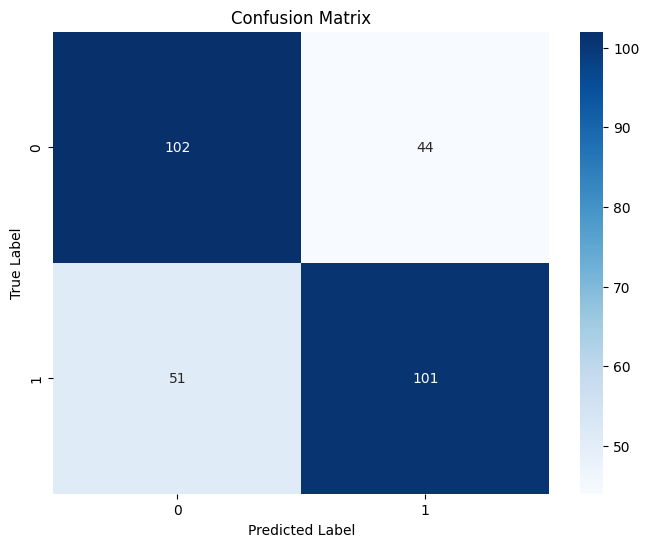

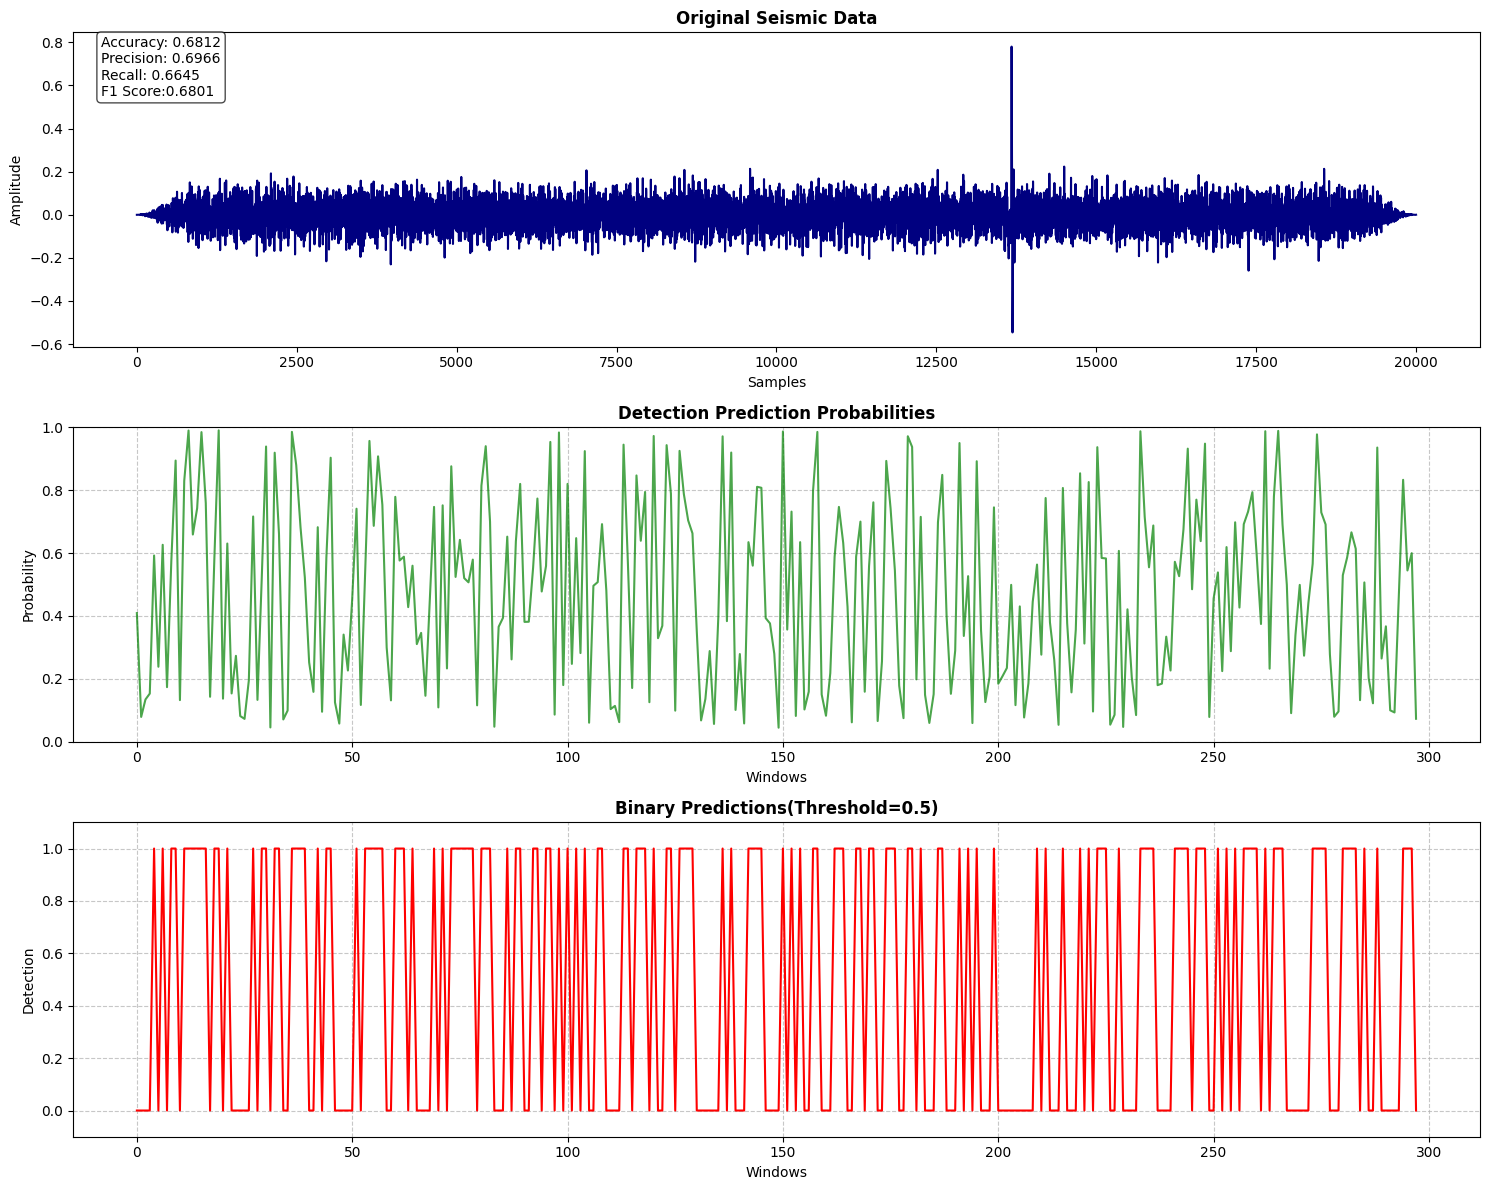

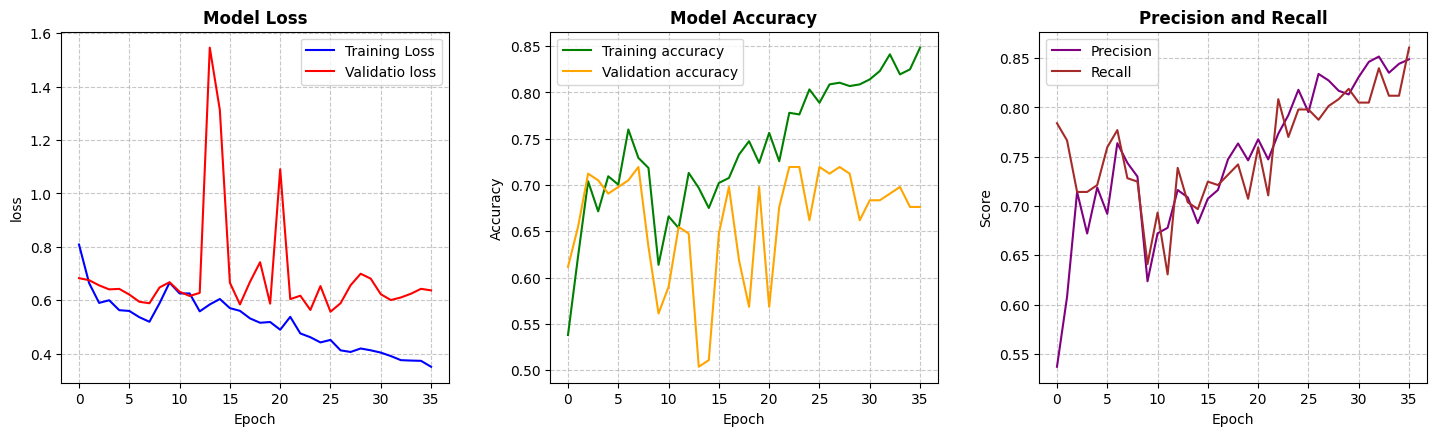

In [ ]:
if __name__=="__main__":
  main(use_real_data=True)